In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm
from IPython.display import display, Markdown
from collections import defaultdict

# set up the environment
%matplotlib inline
plt.rc("figure", figsize=(16, 6))  # set default size of plots
plt.rc("savefig", dpi=90)  # set default size of saved figures
plt.rc("font", family="sans-serif")  # set default font
plt.rc("font", size=14)  # set default font size
sns.set_style("whitegrid")  # set default seaborn style
rng = np.random.default_rng()  # random generator

In [2]:
def lef_tail(samples):
    """Function to calculate the fraction of samples in the left tail of the distribution.

    Args:
        samples (numpy.ndarray): Array of samples.

    Returns:
        float: the fraction of samples less than 2 standard deviations from the mean.
    """
    mean = np.mean(samples)
    std = np.std(samples)
    return np.mean(samples < mean - 2 * std).astype(float)

## Question 4.1

In [3]:
# parameters
S0 = 100  # initial stock price
r = 0.05  # risk-free rate
q = 0.02  # dividend yield
T = 1  # maturity
sigma1 = 0.2  # volatility 1
sigma2 = 0.5  # volatility 2
N = 500  # number of simulations

In [4]:
# simulate log(S_T) using the mixture of two normal distributions
z = rng.standard_normal(size=N)  # standard normal random numbers (size N)
x = (rng.random(size=N) < 0.5).astype(int)  # 0 or 1 with equal probability (1/2)
sigma = sigma1 * x + sigma2 * (1 - x)  # volatility
log_ST = np.log(S0) + (r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z

# statistics of log(S_T)
display(Markdown(f"- Mean: {np.mean(log_ST):.2f}"))
display(Markdown(f"- Standard deviation: {np.std(log_ST):.2f}"))
display(Markdown(f"- Skewness: {skew(log_ST):.2f}"))
display(
    Markdown(f"- Excess kurtosis: {kurtosis(log_ST):.2f}")
)  # kurtosis() returns excess kurtosis as default
display(Markdown(f"- Left tail $(<\mu - 2 \sigma)$: {lef_tail(log_ST) * 100:.2f}%"))

- Mean: 4.56

- Standard deviation: 0.36

- Skewness: -0.23

- Excess kurtosis: 0.75

- Left tail $(<\mu - 2 \sigma)$: 4.40%

The positive excess kurtosis $(>0)$, as well as a large fraction that lie more than two standard deviations below the mean $(> 2.275\%)$, indicate a "fat-tailed" distribution.

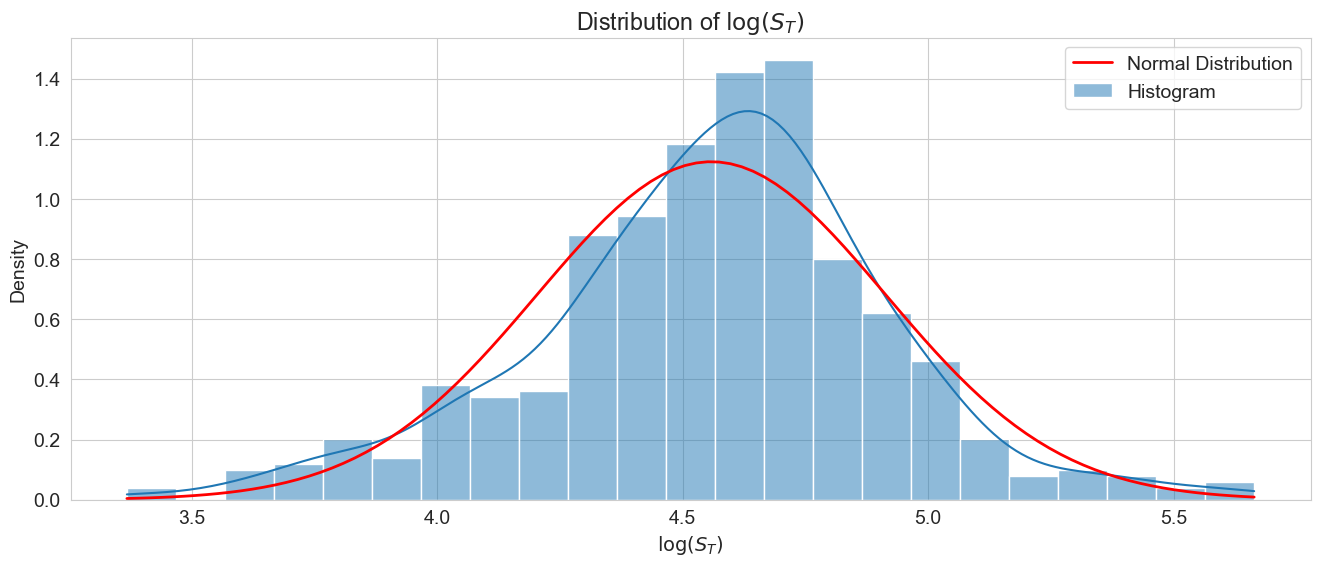

In [5]:
# Plot the histogram
fig, ax = plt.subplots()
sns.histplot(log_ST, kde=True, ax=ax, stat="density", label="Histogram")
x = np.linspace(np.min(log_ST), np.max(log_ST), 100)
y = norm.pdf(x, np.mean(log_ST), np.std(log_ST))
ax.plot(
    x,
    y,
    "r",
    lw=2,
    label=r"Normal Distribution",
)
ax.set_xlabel(r"$\log(S_T)$")
ax.legend()
ax.set_title(r"Distribution of $\log(S_T)$")
plt.show()

As the figure shows, compared to the normal distribution with the same mean and standard deviation, the distribution of the data has a fatter tail and a higher peak.

## Question 4.2

The GARCH (1, 1) model is given by:
$$\log(S_t) - \log(S_{t-1}) = (r - q - \frac{1}{2} \sigma_{t}^2) dt + \epsilon_t \sqrt{dt}$$
$$\sigma_t^2 = a + b \epsilon_{t-1}^2 + c \sigma_{t-1}^2 = \kappa \theta + (1 - \kappa) \left[(1 - \lambda)\epsilon_{t-1}^2 + \lambda\sigma_{t-1}^2\right]$$
$$\epsilon_t = \sigma_t z_t, \qquad z_t \sim N(0, 1) $$


In [6]:
def simulating_GARCH(
    S0=100,  # initial stock price
    r=0.05,  # risk-free rate
    q=0.02,  # dividend yield
    N=100,  # number of time steps
    _kappa=0.02,
    _lambda=0.02,
    _theta=0.09,
    sigma0=0.3,  # initial volatility
    n_samples=500,  # number of simulations
):
    # empty arrays for the results
    sigma = np.zeros((n_samples, N))
    log_S = np.zeros((n_samples, N))
    epsilon = np.zeros((n_samples, N))
    # initial values
    sigma[:, 0] = sigma0
    log_S[:, 0] = np.log(S0)
    epsilon[:, 0] = rng.standard_normal(size=n_samples) * sigma[:, 0]
    dt = 1 / N
    # simulate the process
    for i in range(1, N):
        sigma[:, i] = np.sqrt(
            _kappa * _theta
            + (1 - _kappa) * (1 - _lambda) * epsilon[:, i - 1] ** 2
            + (1 - _kappa) * _lambda * sigma[:, i - 1] ** 2
        )
        epsilon[:, i] = rng.standard_normal(size=n_samples) * sigma[:, i]
        log_S[:, i] = (
            log_S[:, i - 1]
            + (r - q - 0.5 * sigma[:, i] ** 2) * dt
            + epsilon[:, i] * np.sqrt(dt)
        )
    return log_S[:, -1]

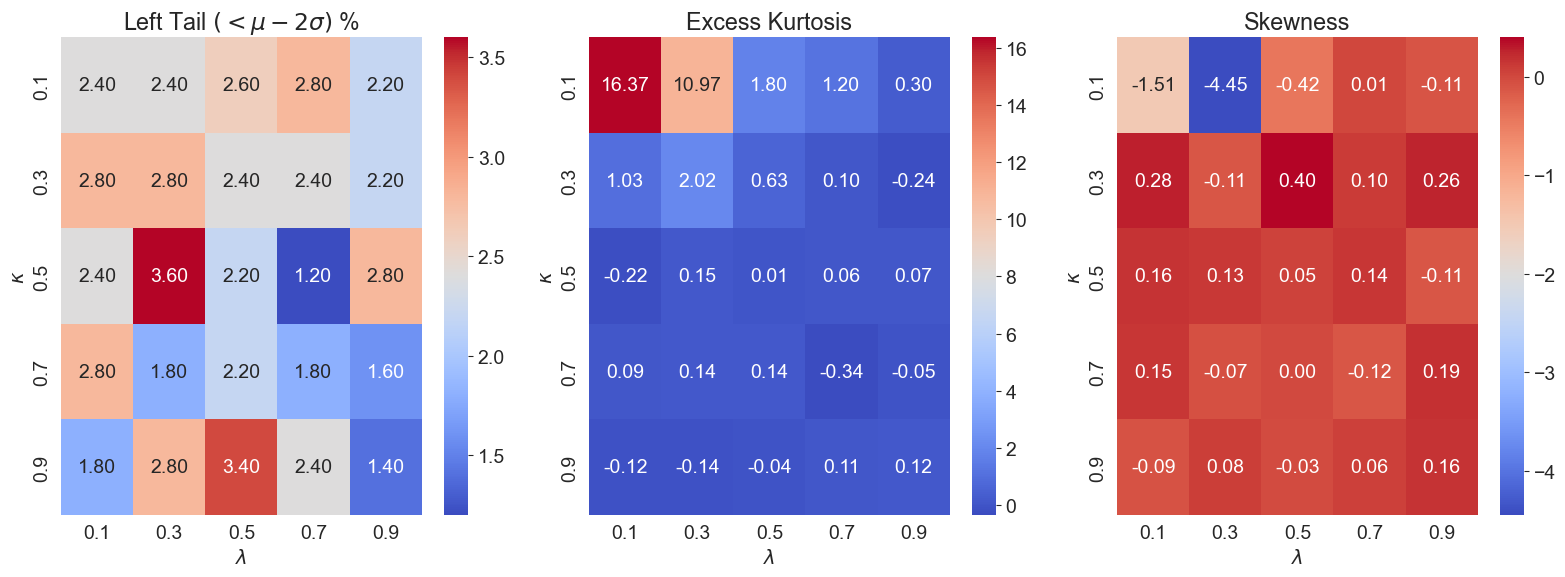

In [7]:
# range of parameters
kappa_list = [0.1, 0.3, 0.5, 0.7, 0.9]
lambda_list = [0.1, 0.3, 0.5, 0.7, 0.9]
# Create a MultiIndex from the cross terms of the two Series
multi_index = pd.MultiIndex.from_product(
    [kappa_list, lambda_list], names=["kappa", "lambda"]
)
# for each pair of parameters, simulate the GARCH process and calculate the skewness, kurtosis and left tail
tails = pd.DataFrame(index=multi_index).reset_index()
tails = tails.assign(
    kurt=lambda x: x.apply(
        lambda y: kurtosis(simulating_GARCH(_kappa=y["kappa"], _lambda=y["lambda"])),
        axis=1,
    ),
    skewness=lambda x: x.apply(
        lambda y: skew(simulating_GARCH(_kappa=y["kappa"], _lambda=y["lambda"])),
        axis=1,
    ),
    tail=lambda x: x.apply(
        lambda y: lef_tail(simulating_GARCH(_kappa=y["kappa"], _lambda=y["lambda"]))
        * 100,
        axis=1,
    ),
)
# plot the results
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
# plot the corresponding heatmaps for the fraction that lie more than 2 standard deviations from the mean
sns.heatmap(
    pd.pivot_table(tails, values="tail", index="kappa", columns="lambda"),
    ax=ax[0],
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)
ax[0].set_title("Left Tail $(<\mu - 2 \sigma)$ %")
ax[0].set_xlabel(r"$\lambda$")
ax[0].set_ylabel(r"$\kappa$")
# plot the corresponding heatmaps for the kurtosis of each sample
sns.heatmap(
    pd.pivot_table(tails, values="kurt", index="kappa", columns="lambda"),
    ax=ax[1],
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)
ax[1].set_title("Excess Kurtosis")
ax[1].set_xlabel(r"$\lambda$")
ax[1].set_ylabel(r"$\kappa$")
# plot the corresponding heatmaps for the skewness of each sample
sns.heatmap(
    pd.pivot_table(tails, values="skewness", index="kappa", columns="lambda"),
    ax=ax[2],
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)
ax[2].set_title("Skewness")
ax[2].set_xlabel(r"$\lambda$")
ax[2].set_ylabel(r"$\kappa$")
plt.tight_layout()
plt.show()

The results of left tail seem to be ambiguous, while the results of excess kurtosis indicate that the distribution appear to be especially fat-tailed with small values of $\kappa$ and $\lambda$. When both $\kappa$ and $\lambda$ are small, the volatility is mainly driven by the random innovations ($\epsilon$), far from the constant volatility assumption of the Black-Scholes model (where the $\log(S_T)$ is normally distributed).

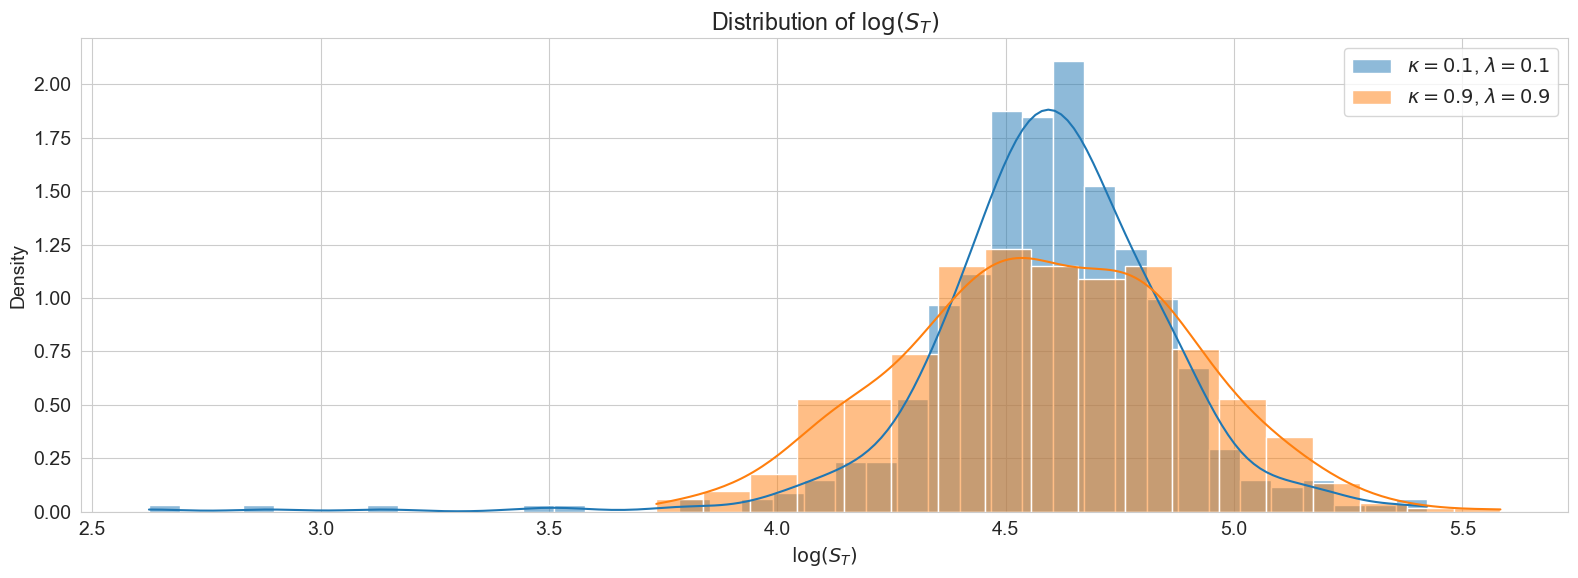

In [8]:
# samples with low and high persistence
low = simulating_GARCH(_kappa=0.1, _lambda=0.1)
high = simulating_GARCH(_kappa=0.9, _lambda=0.9)

fig, ax = plt.subplots()
sns.histplot(low, kde=True, stat="density", label=r"$\kappa=0.1$, $\lambda=0.1$")
sns.histplot(high, kde=True, stat="density", label=r"$\kappa=0.9$, $\lambda=0.9$")
ax.set_title(r"Distribution of $\log(S_T)$")
ax.set_xlabel(r"$\log(S_T)$")
ax.legend()
plt.tight_layout()
plt.show()

The above figure also support that the distribution appear to be especially fat-tailed with small values of $\kappa$ and $\lambda$.

## Question 4.3

The Heston stochastic volatility model is given by:
$$\log(S_{t+1}) - \log(S_{t}) = \left(r - q - \frac{1}{2} \sigma_{t}^2\right) dt + \sqrt{v_{t}} z_t \sqrt{dt}$$
$$v_{t+1} = \max\{v_t + \kappa(\theta - v_t) dt + \gamma \sqrt{v_t} z^{*}_t \sqrt{dt}, 0\}$$
$$\sigma_t^2 = v_t$$
$$z_t = z^1_t, \quad z^{*}_t = \rho z^1_t + \sqrt{1 - \rho^2} z^2_t$$
$$z^1_t \sim N(0, 1), \quad z^2_t \sim N(0, 1)$$

In [9]:
def stochastic_volatility(
    S0=100,  # initial stock price
    V0=0.09,  # initial volatility
    r=0.05,  # risk-free rate
    q=0.02,  # dividend yield
    N=100,  # number of time steps
    _theta=0.09,  # long-term volatility
    _kappa=0.01,  # mean reversion speed
    _gamma=0.01,  # volatility of volatility
    _rho=1,  # correlation of two Brownian motions
    n_samples=500,  # number of simulations
):
    # empty arrays for the results
    log_S = np.zeros((n_samples, N))
    V = np.zeros((n_samples, N))
    # random numbers
    Z = rng.standard_normal((n_samples, N))
    Z2 = rng.standard_normal((n_samples, N))
    Z_star = _rho * Z + np.sqrt(1 - _rho**2) * Z2
    # initial values
    log_S[:, 0] = np.log(S0)
    V[:, 0] = V0
    dt = 1 / N
    # iteration
    for i in range(1, N):
        log_S[:, i] = (
            log_S[:, i - 1]
            + (r - q - 0.5 * V[:, i - 1]) * dt
            + np.sqrt(V[:, i - 1] * dt) * Z[:, i]
        )
        V[:, i] = (
            V[:, i - 1]
            + _kappa * (_theta - V[:, i - 1]) * dt
            + _gamma * np.sqrt(V[:, i - 1] * dt) * Z_star[:, i]
        )
        V[:, i] = np.maximum(V[:, i], 0)
    return log_S[:, -1]

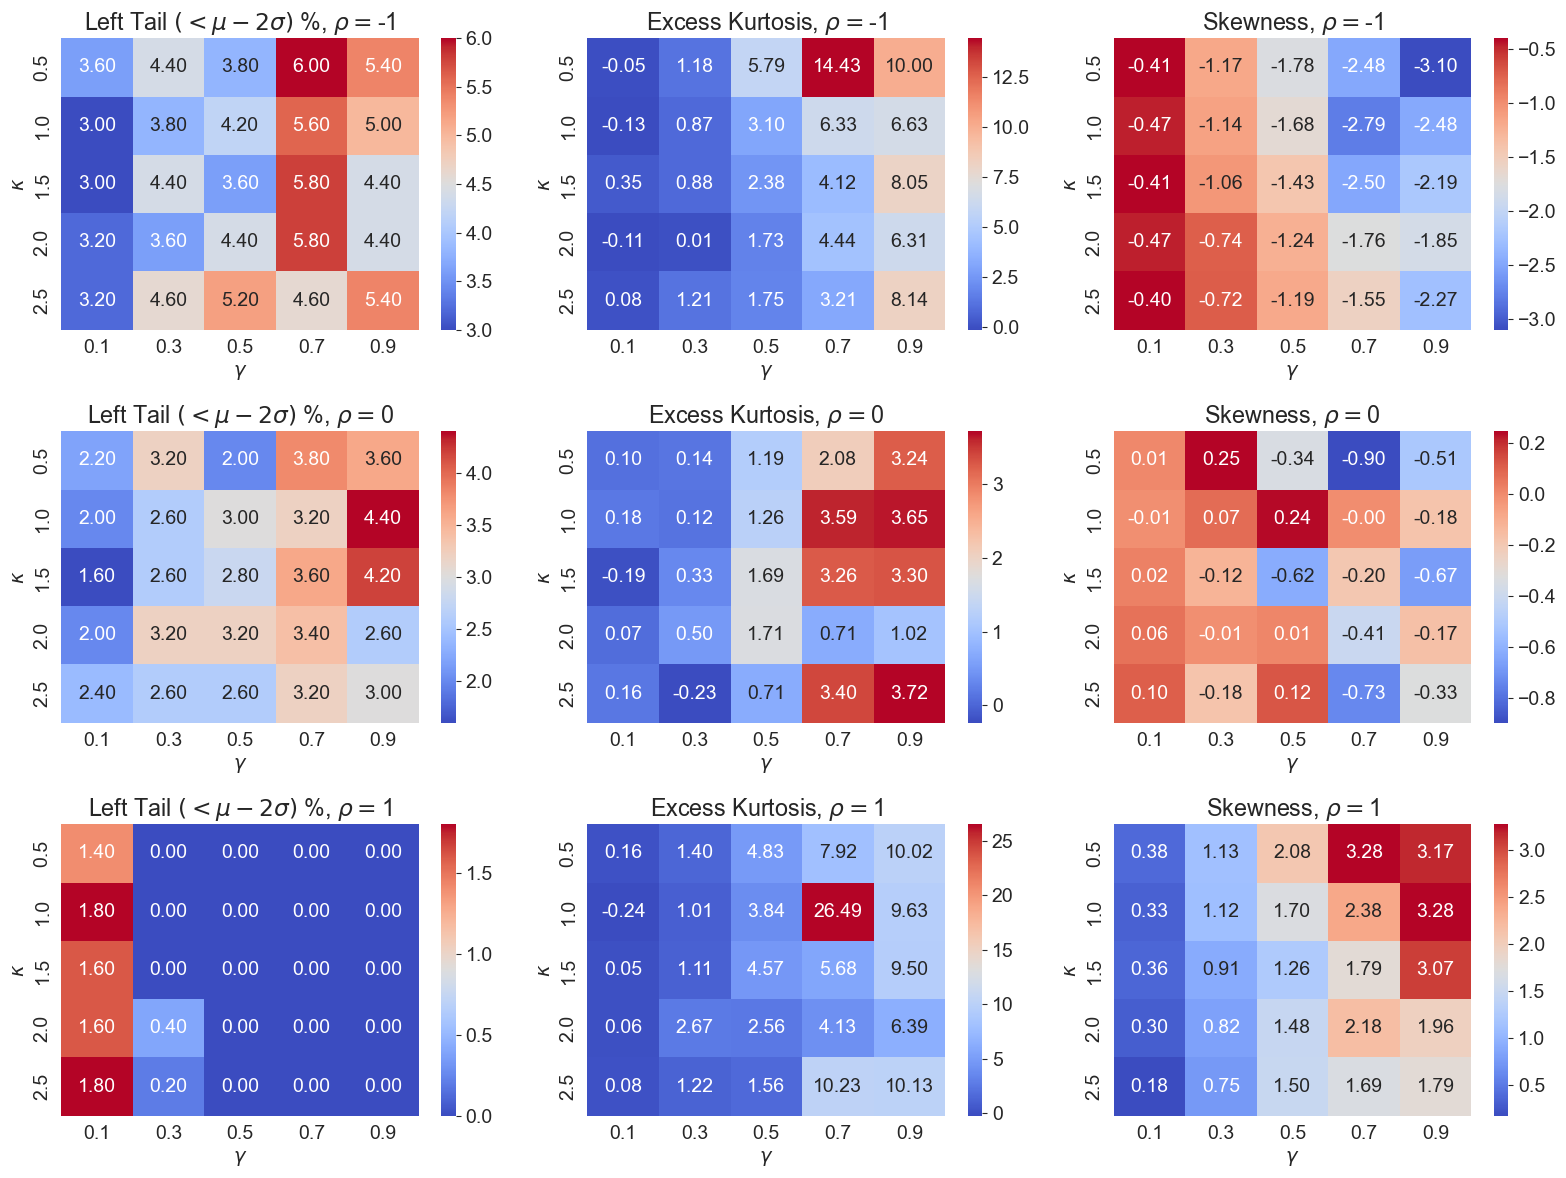

In [10]:
# range of parameters
kappa_list = [0.5, 1, 1.5, 2, 2.5]
gamma_list = [0.1, 0.3, 0.5, 0.7, 0.9]
rho_list = [-1, 0, 1]
# Create a MultiIndex from the cross terms of the two Series
multi_index = pd.MultiIndex.from_product(
    [kappa_list, gamma_list], names=["kappa", "gamma"]
)
# for each pair of parameters, simulate the GARCH process and calculate the skewness, kurtosis and left tail
tails = defaultdict()
for rho in rho_list:
    tails[rho] = pd.DataFrame(index=multi_index).reset_index()
    tails[rho] = tails[rho].assign(
        kurt=lambda x: x.apply(
            lambda y: kurtosis(
                stochastic_volatility(_kappa=y["kappa"], _gamma=y["gamma"], _rho=rho)
            ),
            axis=1,
        ),
        skewness=lambda x: x.apply(
            lambda y: skew(
                stochastic_volatility(_kappa=y["kappa"], _gamma=y["gamma"], _rho=rho)
            ),
            axis=1,
        ),
        tail=lambda x: x.apply(
            lambda y: lef_tail(
                stochastic_volatility(_kappa=y["kappa"], _gamma=y["gamma"], _rho=rho)
            )
            * 100,
            axis=1,
        ),
    )
# plot the results
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, rho in enumerate(rho_list):
    # plot the corresponding heatmaps for the fraction that lie more than 2 standard deviations from the mean
    sns.heatmap(
        pd.pivot_table(tails[rho], values="tail", index="kappa", columns="gamma"),
        ax=ax[i, 0],
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
    )
    ax[i, 0].set_title(r"Left Tail $(<\mu - 2 \sigma)$ %, $\rho=$" + str(rho))
    ax[i, 0].set_xlabel(r"$\gamma$")
    ax[i, 0].set_ylabel(r"$\kappa$")
    # plot the corresponding heatmaps for the kurtosis of each sample
    sns.heatmap(
        pd.pivot_table(tails[rho], values="kurt", index="kappa", columns="gamma"),
        ax=ax[i, 1],
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
    )
    ax[i, 1].set_title(r"Excess Kurtosis, $\rho=$" + str(rho))
    ax[i, 1].set_xlabel(r"$\gamma$")
    ax[i, 1].set_ylabel(r"$\kappa$")
    # plot the corresponding heatmaps for the skewness of each sample
    sns.heatmap(
        pd.pivot_table(tails[rho], values="skewness", index="kappa", columns="gamma"),
        ax=ax[i, 2],
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
    )
    ax[i, 2].set_title(r"Skewness, $\rho=$" + str(rho))
    ax[i, 2].set_xlabel(r"$\gamma$")
    ax[i, 2].set_ylabel(r"$\kappa$")
plt.tight_layout()
plt.show()

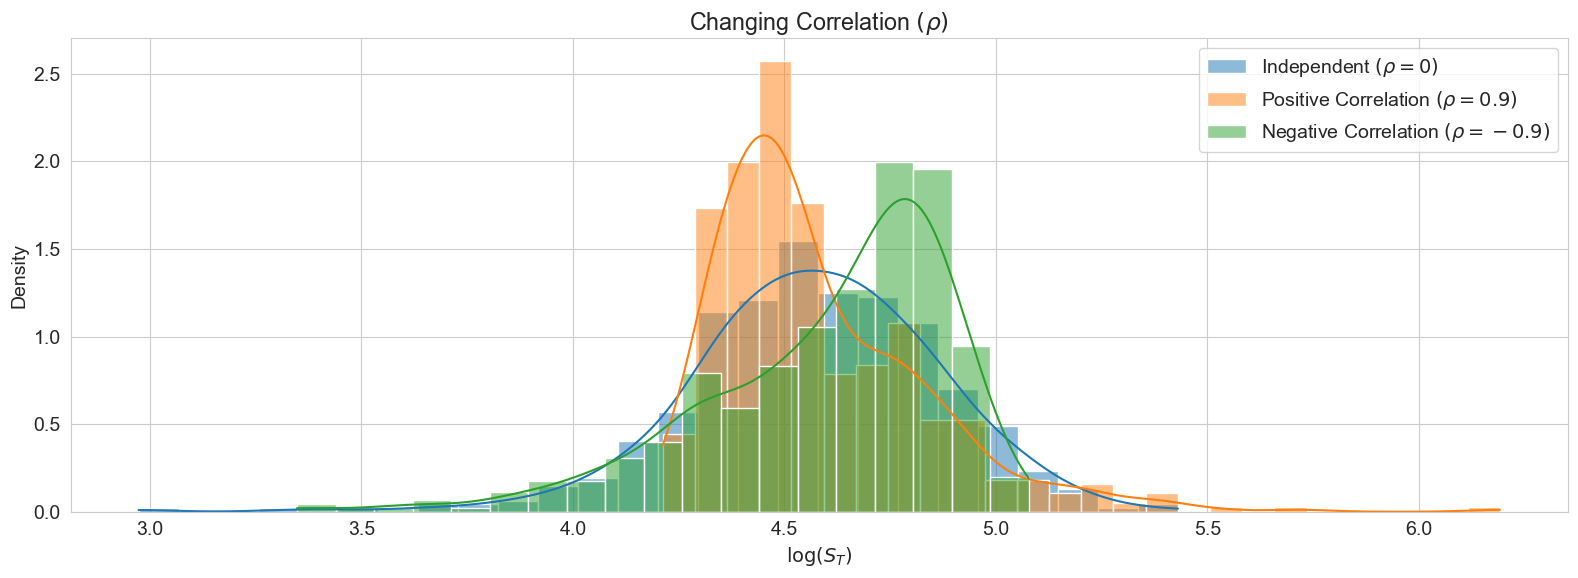

In [11]:
# Changing correlation
zero = stochastic_volatility(_kappa=1, _gamma=0.5, _rho=0)  # base case
positive = stochastic_volatility(_kappa=1, _gamma=0.5, _rho=0.9)  # positive correlation
negative = stochastic_volatility(
    _kappa=1, _gamma=0.5, _rho=-0.9
)  # negative correlation
# plot the results
fig, ax = plt.subplots()
sns.histplot(zero, kde=True, ax=ax, stat="density", label=r"Independent $(\rho=0)$")
sns.histplot(
    positive,
    kde=True,
    stat="density",
    label=r"Positive Correlation $(\rho=0.9)$",
)
sns.histplot(
    negative,
    kde=True,
    stat="density",
    label=r"Negative Correlation $(\rho=-0.9)$",
)
ax.set_title(r"Changing Correlation $(\rho)$")
ax.set_xlabel(r"$\log(S_T)$")
ax.legend()
plt.tight_layout()
plt.show()

From the heatmap and the histogram, we can see that:
1. Positive correlation $(\rho > 0)$ creating a positive (right) skewness, which has a long right tail.
2. Negative correlation $(\rho < 0)$ creating a negative (left) skewness, which has a long left tail.

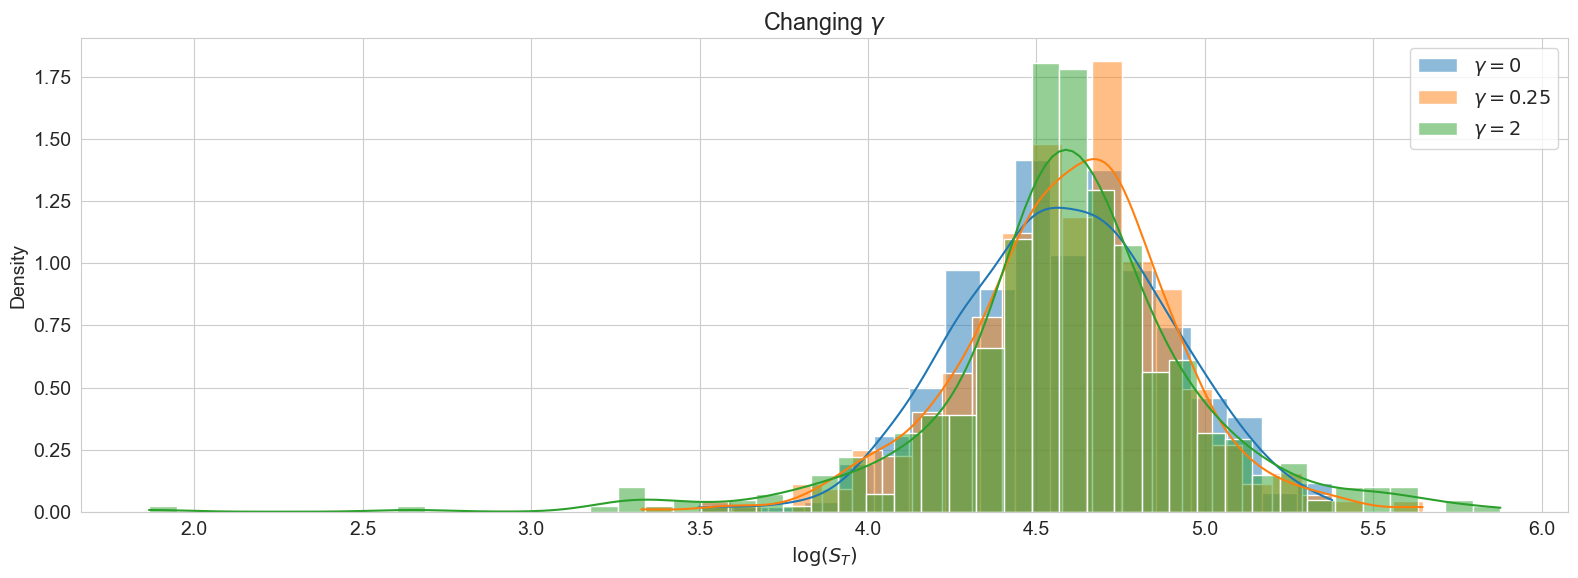

In [14]:
# Changing gamma
zero = stochastic_volatility(_kappa=1, _gamma=0, _rho=0)  # base case
gamma_1 = stochastic_volatility(_kappa=1, _gamma=0.5, _rho=0)  # high gamma
gamma_2 = stochastic_volatility(_kappa=1, _gamma=2, _rho=0)  # low gamma
# plot the results
fig, ax = plt.subplots()
sns.histplot(zero, kde=True, ax=ax, stat="density", label=r"$\gamma=0$")
sns.histplot(gamma_1, kde=True, ax=ax, stat="density", label=r"$\gamma=0.25$")
sns.histplot(gamma_2, kde=True, ax=ax, stat="density", label=r"$\gamma=2$")
ax.set_title(r"Changing $\gamma$")
ax.set_xlabel(r"$\log(S_T)$")
ax.legend()
plt.tight_layout()
plt.show()

From the heatmap and the histogram, we can see that, higher values of $\gamma$, that is the higher volatility of volatility, the more fat-tailed the distribution is.

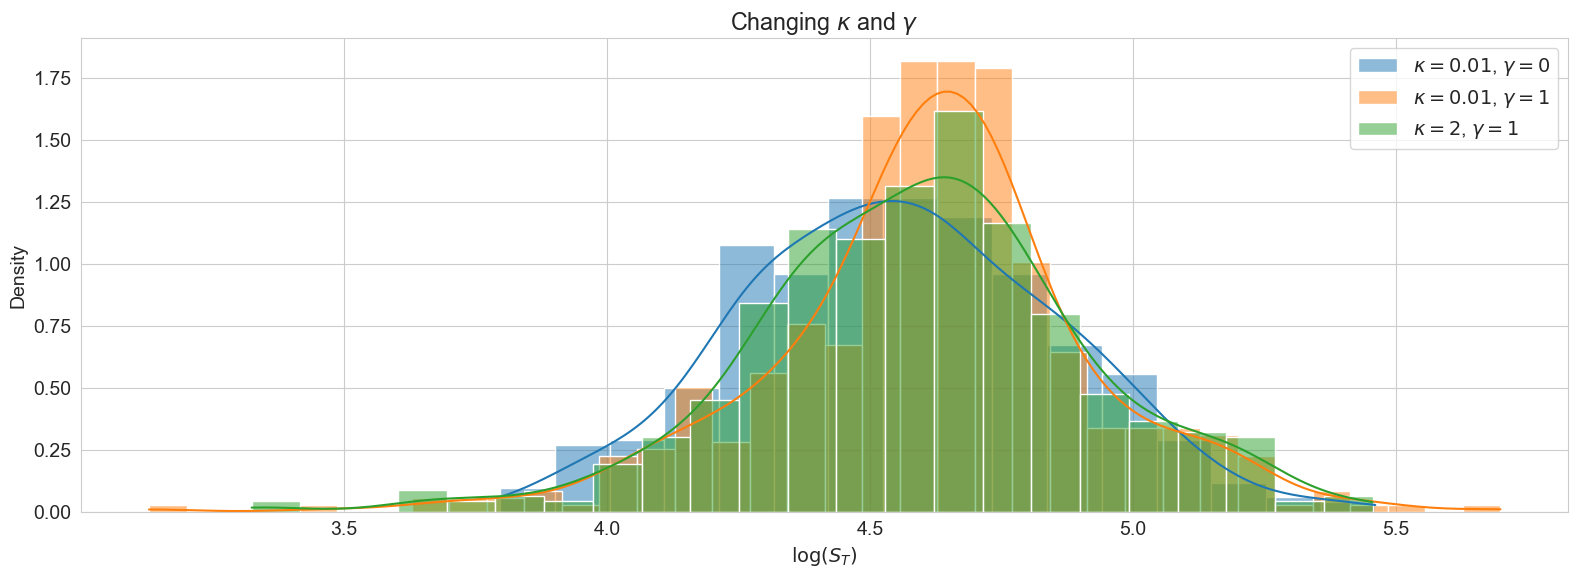

In [13]:
# Changing kappa and gamma
kappa_0 = stochastic_volatility(_kappa=0.01, _gamma=0, _rho=0)  # base case
kappa_1 = stochastic_volatility(_kappa=0.01, _gamma=0.5, _rho=0)  # high kappa
kappa_2 = stochastic_volatility(_kappa=2, _gamma=0.5, _rho=0)  # low kappa
# plot the results
fig, ax = plt.subplots()
sns.histplot(
    kappa_0, kde=True, ax=ax, stat="density", label=r"$\kappa=0.01$, $\gamma=0$"
)
sns.histplot(
    kappa_1, kde=True, ax=ax, stat="density", label=r"$\kappa=0.01$, $\gamma=1$"
)
sns.histplot(kappa_2, kde=True, ax=ax, stat="density", label=r"$\kappa=2$, $\gamma=1$")
ax.set_title(r"Changing $\kappa$ and $\gamma$")
ax.set_xlabel(r"$\log(S_T)$")
ax.legend()
plt.tight_layout()
plt.show()

From the heatmap and the histogram, we can see that, lower values of $\kappa$, that is the slower mean reversion, the more fat-tailed the distribution is, especially when $\gamma$ is high.

Overall, we can conclude as:
1. The Heston model can generate fat-tailed distributions, especially when $\kappa$ is low and $\gamma$ is high.
2. The correlation $\rho$ can also affect the skewness of the distribution, and create a long one-sided tail.